Idea for tuning:

need to specify which metrics need to be computed, which one needs to be minimized, and how large k is

* build k splits into train and test data
* for each train-test-split:
    * build a parameter grid using cls.tuning_params. (For each class we have to find out what a good grid would be.)
    * for each combination in the grid: 
        * translate api-response into f,m,u and store in the column gender_infered 
        * compute all provided metrics on the resulting test_data DF restricted to training data
        * store relation grid-point:metrics
    * select grid_point which minimizes specified metric and compute all provided metrics on test set
    * store the metrics on test set
* compute average of metrics on all test sets for all metrics

In [1]:
import pandas as pd
import numpy as np
from evaluators import *
from helpers import REGISTERED_EVALUATORS

import matplotlib.ticker as mtick
from mpltools import style
style.use('ggplot')
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/mpltools/style/__init__.py:42: FutureWarning: 

    The style-sheet functionality in mpltools has been integrated into
    Matplotlib >= 1.4. This module will be removed in a future release.

    Note that style-sheets used by `matplotlib.style` use the standard
    Matplotlib rc-file syntax instead of the INI format used by `mpltools`.
    This mostly means un-quoting strings and changing '=' to ':'.


  """, FutureWarning)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['style']
`%matplotlib` prevents importing * 

## Discretize distribution of tuning parameters

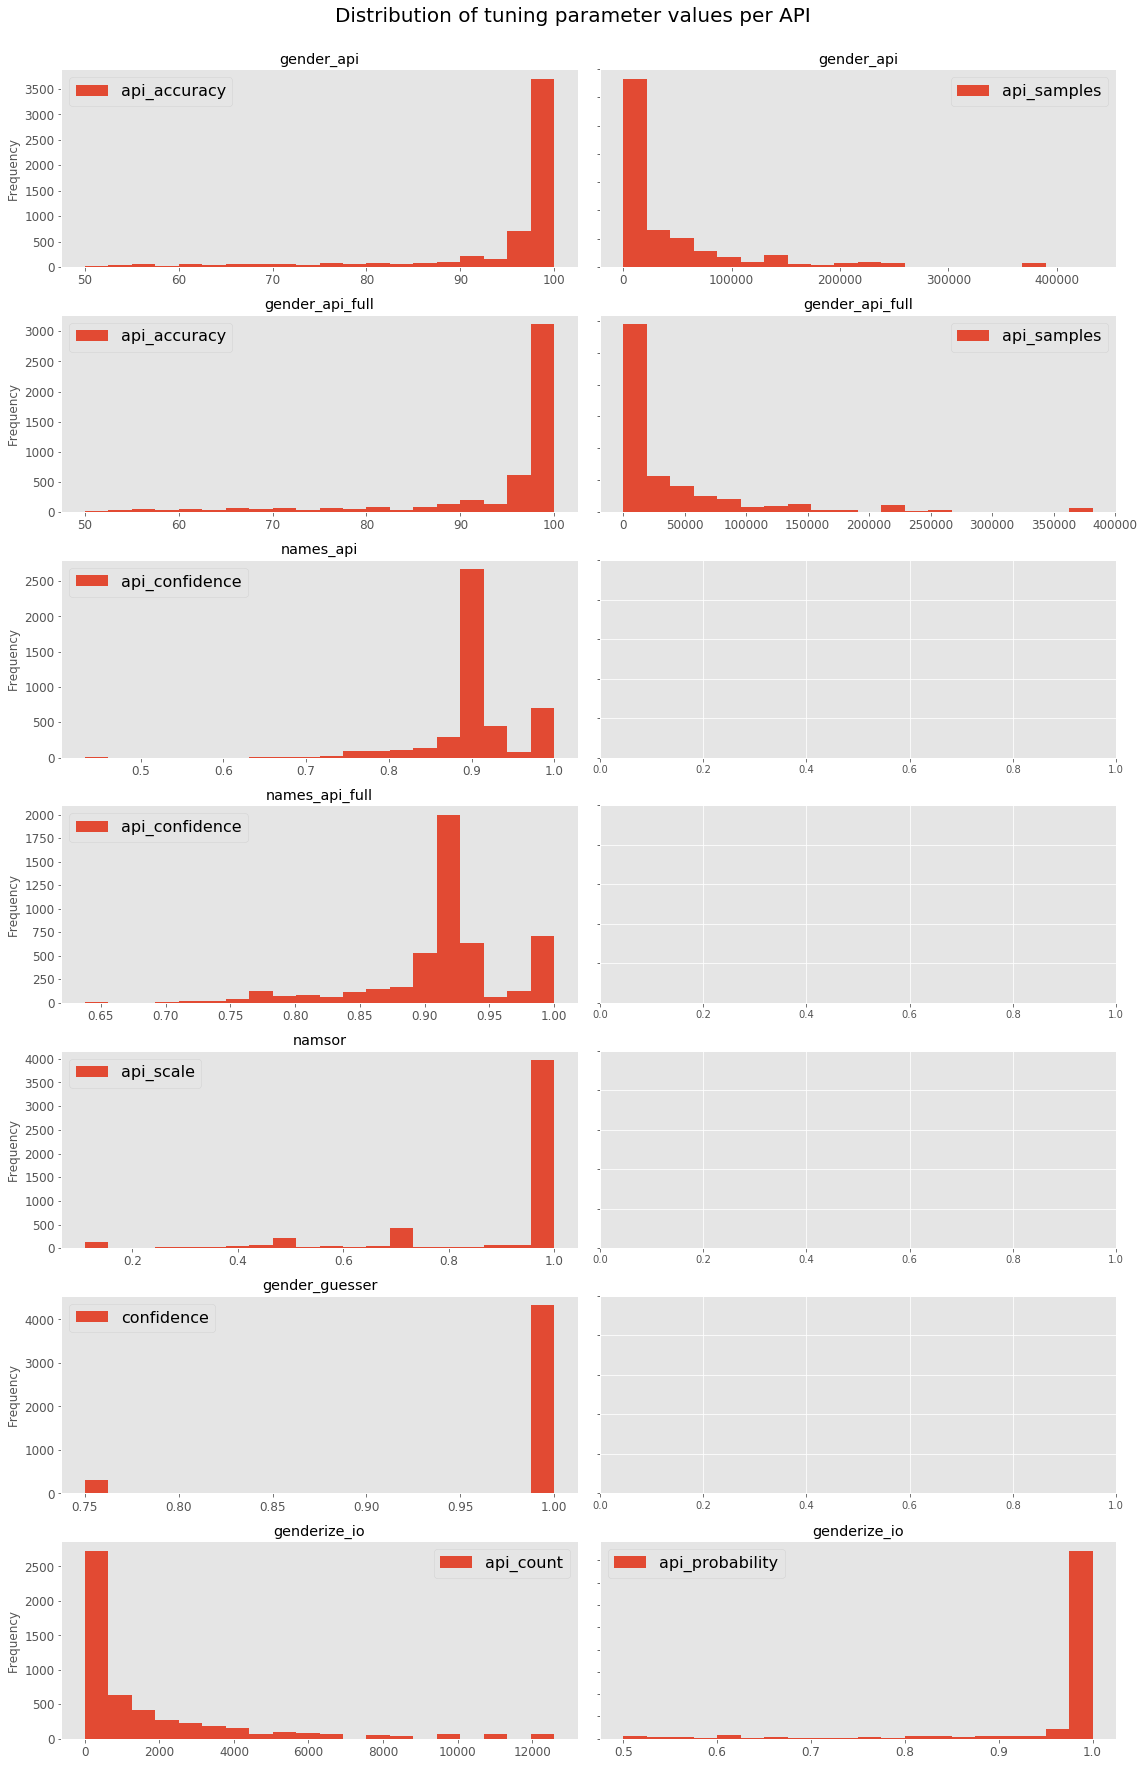

In [9]:
rows = len(REGISTERED_EVALUATORS)
cols = 2
fs=12
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 24))
#cmap = plt.get_cmap('YlGnBu')

formatter = FuncFormatter(lambda v, pos: str(v * 100)) # from: https://github.com/matplotlib/matplotlib/issues/320/

for i, s in enumerate(REGISTERED_EVALUATORS):    
    evaluator = s('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_data_for_parameter_tuning()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=True, gender_infered=True)
    #print(len(evaluator.test_data[evaluator.test_data.gender == 'u']))
    #print(len(evaluator.test_data[(evaluator.test_data.gender_infered != 'f') & (evaluator.test_data.gender_infered != 'm')]))
    #print(len(evaluator.test_data))
    for j, param in enumerate(list(evaluator.tuning_params)):
        evaluator.test_data[[param]].plot(ax=axes[i][j], kind='hist', stacked=False, title=s.gender_evaluator, 
                                         sharey=True, fontsize=fs, grid=False, bins=20 #, normed=True
                                         )
        
        axes[i][j].legend(loc='best', fontsize=fs+4)
        #axes[i][j].yaxis.set_major_formatter(formatter)
        #axes[i][j].set_ylabel('')

plt.suptitle('Distribution of tuning parameter values per API', fontsize=20, y=1.02)

fig.tight_layout()

### Use quantiles

In [18]:
# test on genderize_io
tuning_param = 'api_count'
evaluator = REGISTERED_EVALUATORS[-1]('all')
evaluator.load_data(evaluated=True)
evaluator.preprocess_data_for_parameter_tuning()
evaluator.remove_rows_with_unknown_gender(gender=True, gender_infered=True)

data = evaluator.test_data[tuning_param]
evaluator.test_data['api_bins'] = pd.qcut(data, 5, duplicates='drop')

In [19]:
evaluator.test_data.head()

,index,first_name,middle_name,last_name,full_name,gender,origin,api_count,api_gender,api_name,api_probability,gender_infered,api_bins
0,0,pierre,paul,grivel,pierre paul grivel,m,zbmath,5.0,male,pierre-paul,1.00,m,"(0.999, 26.0]"
1,1,raul,,serapioni,raul serapioni,m,zbmath,821.0,male,raul,1.00,m,"(212.0, 991.0]"
2,2,adriano,,moura,adriano moura,m,zbmath,166.0,male,adriano,0.99,m,"(26.0, 212.0]"
3,3,ralf,,kieser,ralf kieser,m,zbmath,86.0,male,ralf,1.00,m,"(26.0, 212.0]"
4,5,guillermo,,leon-de-la-barra,guillermo leon-de-la-barra,m,zbmath,850.0,male,guillermo,1.00,m,"(212.0, 991.0]"


In [20]:
def compute_equal_frequency_binning(param_values, k):
    """Takes a list of values (e.g. of a tuning parameter) and an integer k, and returns the lower 
    quantile boundaries for k quantiles. Corresponds to equal-frequency binning."""
    bins = pd.qcut(param_values, k, duplicates='drop')
    left_boundaries = []

    for b in bins:
        left_boundaries.append(b.left)
    return sorted(list(set(left_boundaries)))

In [21]:
compute_equal_frequency_binning(evaluator.test_data[tuning_param], 5)

[0.999, 26.0, 212.0, 991.0, 2704.0]

In [22]:
compute_equal_frequency_binning(evaluator.test_data[tuning_param], 20)

[0.999,
 2.0,
 6.0,
 14.0,
 26.0,
 46.0,
 78.0,
 123.2,
 212.0,
 330.0,
 503.0,
 738.20000000000005,
 991.0,
 1324.0,
 1663.0,
 2201.0,
 2704.0,
 3753.0,
 5168.0,
 8180.0]

## `genderize_io`

In [3]:
data_source = 'all'
service_name = GenderizeIoEvaluator
evaluator = service_name(data_source)

# pre-processing before tuning. needs to be done only once
evaluator.load_data(evaluated=True)
evaluator.preprocess_data_for_parameter_tuning()
evaluator.remove_rows_with_unknown_gender()
evaluator.shuffle_data()

In [4]:
evaluator.test_data.head()

,level_0,index,first_name,middle_name,last_name,full_name,gender,origin,api_count,api_gender,api_name,api_probability,gender_infered
0,2623,2841,nadeem,,qureshi,nadeem qureshi,m,filardo,74.0,male,nadeem,1.00,m
1,3269,3495,suryun,,ham,suryun ham,f,nature,NaN,,suryun,NaN,u
2,3957,4284,petra,,schuster,petra schuster,f,nature,588.0,female,petra,0.99,f
3,3766,3992,hyun,myung,jang,hyun myung jang,m,nature,27.0,male,hyun,0.63,m
4,1941,2148,jonathan,,hill,jonathan hill,m,filardo,3702.0,male,jonathan,1.00,m


In [6]:
evaluator.test_data[list(evaluator.tuning_params)].describe()

,api_count,api_probability
count,5227.000000,5227.000000
mean,1695.015496,0.957744
std,2638.971903,0.105776
min,1.000000,0.500000
25%,46.000000,0.990000
50%,503.000000,1.000000
75%,2201.000000,1.000000
max,12593.000000,1.000000


In [7]:
# show confusion matrix if we do no tuning
evaluator._translate_api_response()
evaluator.compute_confusion_matrix(evaluator.test_data)

,f_pred,m_pred,u_pred
f,1722,88,151
m,220,3197,412
u,0,0,0


In [8]:
# only for testing
evaluator.build_parameter_grid([100, 500, 1000], [0.8, 0.85, 0.9])

[OrderedDict([('api_count', 100), ('api_probability', 0.8)]),
 OrderedDict([('api_count', 100), ('api_probability', 0.85)]),
 OrderedDict([('api_count', 100), ('api_probability', 0.9)]),
 OrderedDict([('api_count', 500), ('api_probability', 0.8)]),
 OrderedDict([('api_count', 500), ('api_probability', 0.85)]),
 OrderedDict([('api_count', 500), ('api_probability', 0.9)]),
 OrderedDict([('api_count', 1000), ('api_probability', 0.8)]),
 OrderedDict([('api_count', 1000), ('api_probability', 0.85)]),
 OrderedDict([('api_count', 1000), ('api_probability', 0.9)])]

In [9]:
# build a sample grid
grid = evaluator.build_parameter_grid([1, 10, 100, 200, 300], 
                                      [0.5, 0.7, 0.8, 0.9, 0.95, 0.97, 0.98, 0.98, 1])

In [10]:
# TODO: turn errors into a nice dataframe for the paper 
index = evaluator.test_data.index
errors = evaluator.compute_error_for_param_grid(grid, evaluator.compute_error_without_unknown, index)
errors 

{(1, 0.5): 0.058924813468528792,
 (1, 0.7): 0.037021969080553295,
 (1, 0.8): 0.031067556296914094,
 (1, 0.9): 0.024731888815933464,
 (1, 0.95): 0.020702070207020702,
 (1, 0.97): 0.019462465245597776,
 (1, 0.98): 0.019458946369245372,
 (1, 1): 0.021270221689634512,
 (10, 0.5): 0.052019315188762072,
 (10, 0.7): 0.030303030303030304,
 (10, 0.8): 0.023661567877629065,
 (10, 0.9): 0.017306245297215951,
 (10, 0.95): 0.012428793371310202,
 (10, 0.97): 0.010712372790573112,
 (10, 0.98): 0.010462555066079295,
 (10, 1): 0.0097968069666182871,
 (100, 0.5): 0.035132819194515851,
 (100, 0.7): 0.01854066985645933,
 (100, 0.8): 0.014625228519195612,
 (100, 0.9): 0.0097545626179987421,
 (100, 0.95): 0.0064370775667846793,
 (100, 0.97): 0.0065984823490597162,
 (100, 0.98): 0.0064232589587559161,
 (100, 1): 0.0051139005113900512,
 (200, 0.5): 0.031496062992125984,
 (200, 0.7): 0.015491100856954515,
 (200, 0.8): 0.013368983957219251,
 (200, 0.9): 0.0089500860585197926,
 (200, 0.95): 0.0059711977520196698

### Try standard errors

In [11]:
evaluator.compute_cv_score(5, grid, evaluator.compute_error_with_unknown)

minimal train error: 0.150507449795 corresponding test error: 0.150129421915
params for lowest train error: {'api_probability': 0.5, 'api_count': 1}
minimal train error: 0.15133851468 corresponding test error: 0.146804835924
params for lowest train error: {'api_probability': 0.5, 'api_count': 1}
minimal train error: 0.148100172712 corresponding test error: 0.1597582038
params for lowest train error: {'api_probability': 0.5, 'api_count': 1}
minimal train error: 0.150043177893 corresponding test error: 0.151986183074
params for lowest train error: {'api_probability': 0.5, 'api_count': 1}
minimal train error: 0.152169220807 corresponding test error: 0.143474503025
params for lowest train error: {'api_probability': 0.5, 'api_count': 1}


0.15043062954768732

In [12]:
evaluator.compute_cv_score(5, grid, evaluator.compute_error_without_unknown)

minimal train error: 0.00398406374502 corresponding test error: 0.0057361376673
params for lowest train error: {'api_probability': 0.98, 'api_count': 300}
minimal train error: 0.00328515111695 corresponding test error: 0.00277008310249
params for lowest train error: {'api_probability': 1, 'api_count': 300}
minimal train error: 0.00266489007328 corresponding test error: 0.00523560209424
params for lowest train error: {'api_probability': 1, 'api_count': 300}
minimal train error: 0.00258397932817 corresponding test error: 0.00597014925373
params for lowest train error: {'api_probability': 1, 'api_count': 300}
minimal train error: 0.00336021505376 corresponding test error: 0.00253164556962
params for lowest train error: {'api_probability': 1, 'api_count': 300}


0.004448723537477905

In [13]:
evaluator.compute_cv_score(5, grid, evaluator.compute_error_unknown)

minimal train error: 0.0956596847333 corresponding test error: 0.103537532355
params for lowest train error: {'api_probability': 0.5, 'api_count': 1}
minimal train error: 0.097366148532 corresponding test error: 0.0967184801382
params for lowest train error: {'api_probability': 0.5, 'api_count': 1}
minimal train error: 0.0945595854922 corresponding test error: 0.107944732297
params for lowest train error: {'api_probability': 0.5, 'api_count': 1}
minimal train error: 0.0993091537133 corresponding test error: 0.0889464594128
params for lowest train error: {'api_probability': 0.5, 'api_count': 1}
minimal train error: 0.0992877185409 corresponding test error: 0.0890233362143
params for lowest train error: {'api_probability': 0.5, 'api_count': 1}


0.097234108083568027

### Try out a weighted version of `compute_error_with_unknown`

In [14]:
evaluator.compute_cv_score(5, grid, evaluator.compute_weighted_error)

minimal train error: 0.0871299093656 corresponding test error: 0.0804266359181
params for lowest train error: {'api_probability': 0.7, 'api_count': 1}
minimal train error: 0.0865187260039 corresponding test error: 0.0828430899797
params for lowest train error: {'api_probability': 0.7, 'api_count': 1}
minimal train error: 0.0843390908434 corresponding test error: 0.0916171745692
params for lowest train error: {'api_probability': 0.7, 'api_count': 1}
minimal train error: 0.0837027756361 corresponding test error: 0.0941817474217
params for lowest train error: {'api_probability': 0.7, 'api_count': 1}
minimal train error: 0.0872353297036 corresponding test error: 0.0800420770776
params for lowest train error: {'api_probability': 0.7, 'api_count': 1}


0.085822144993257549

In [15]:
# show confusion matrix if we tune parameters according to error function 'compute_weighted_error'
evaluator._translate_api_response(api_count=1, api_probability=0.7)
evaluator.compute_confusion_matrix(evaluator.test_data)

,f_pred,m_pred,u_pred
f,1671,52,238
m,130,3063,636
u,0,0,0


### try setting a constraint

In [16]:
# we tune parameters such that 'error_func' is minimised on the training sets 
# but under the constraint that 'constraint_func' is less than 'constraint_val' on test set
evaluator.compute_cv_score(n_splits=5, param_grid=grid, error_func=evaluator.compute_error_without_unknown,
                          constraint_func=evaluator.compute_error_with_unknown, constraint_val=0.1)

No parameter values satisfied given constraint
No parameter values satisfied given constraint


In [17]:
evaluator.compute_cv_score(n_splits=5, param_grid=grid, error_func=evaluator.compute_error_without_unknown,
                          constraint_func=evaluator.compute_error_with_unknown, constraint_val=0.5)

minimal train error: 0.00618921308576 corresponding test error: 0.00512820512821
params for lowest train error: {'api_probability': 0.95, 'api_count': 200}
minimal train error: 0.00550381033023 corresponding test error: 0.010067114094
params for lowest train error: {'api_probability': 0.98, 'api_count': 100}
minimal train error: 0.00642570281124 corresponding test error: 0.0064829821718
params for lowest train error: {'api_probability': 0.95, 'api_count': 100}
minimal train error: 0.00596184419714 corresponding test error: 0.00846023688663
params for lowest train error: {'api_probability': 0.95, 'api_count': 100}
minimal train error: 0.00668449197861 corresponding test error: 0.00331674958541
params for lowest train error: {'api_probability': 0.95, 'api_count': 200}


0.0066910575732006027

In [18]:
evaluator.compute_cv_score(n_splits=5, param_grid=grid, error_func=evaluator.compute_error_without_unknown,
                          constraint_func=evaluator.compute_error_unknown, constraint_val=0.25)

minimal train error: 0.0192195690157 corresponding test error: 0.0204081632653
params for lowest train error: {'api_probability': 0.97, 'api_count': 1}
minimal train error: 0.0194710839872 corresponding test error: 0.0194285714286
params for lowest train error: {'api_probability': 0.97, 'api_count': 1}
minimal train error: 0.0215565509518 corresponding test error: 0.0172018348624
params for lowest train error: {'api_probability': 0.95, 'api_count': 1}
minimal train error: 0.0198935275988 corresponding test error: 0.024
params for lowest train error: {'api_probability': 0.95, 'api_count': 1}
minimal train error: 0.0208568207441 corresponding test error: 0.0200892857143
params for lowest train error: {'api_probability': 0.95, 'api_count': 1}


0.020225571054109718

## `gender_api`

In [19]:
data_source = 'all'
service_name = GenderAPIEvaluator
evaluator = service_name(data_source)

evaluator.load_data(evaluated=True)
evaluator.preprocess_data_for_parameter_tuning()
evaluator.remove_rows_with_unknown_gender()
evaluator.shuffle_data()

In [20]:
evaluator.tuning_params

('api_accuracy', 'api_samples')

In [21]:
evaluator.test_data[list(evaluator.tuning_params)].describe()

,api_accuracy,api_samples
count,5790.000000,5790.000000
mean,91.385320,40243.978066
std,18.721861,66650.027682
min,0.000000,0.000000
25%,95.000000,987.000000
50%,98.000000,11153.000000
75%,99.000000,51412.000000
max,100.000000,433182.000000


In [22]:
# show confusion matrix if we do no tuning
evaluator._translate_api_response()
evaluator.compute_confusion_matrix(evaluator.test_data)

,f_pred,m_pred,u_pred
f,1728,187,46
m,141,3560,128
u,0,0,0


In [23]:
grid = evaluator.build_parameter_grid([50, 60, 70, 80, 90, 95], [10000, 20000, 30000, 40000, 50000, 60000])

In [24]:
evaluator.compute_cv_score(5, grid, evaluator.compute_error_without_unknown)

minimal train error: 0.00631199278629 corresponding test error: 0.0
params for lowest train error: {'api_samples': 50000, 'api_accuracy': 95}
minimal train error: 0.00575373993096 corresponding test error: 0.0045766590389
params for lowest train error: {'api_samples': 20000, 'api_accuracy': 95}
minimal train error: 0.00456621004566 corresponding test error: 0.00706713780919
params for lowest train error: {'api_samples': 50000, 'api_accuracy': 95}
minimal train error: 0.00223713646532 corresponding test error: 0.0190476190476
params for lowest train error: {'api_samples': 60000, 'api_accuracy': 95}
minimal train error: 0.00562324273664 corresponding test error: 0.0032154340836
params for lowest train error: {'api_samples': 50000, 'api_accuracy': 95}


0.0067813699958618441

In [25]:
evaluator.compute_cv_score(5, grid, evaluator.compute_error_with_unknown)

minimal train error: 0.502267328871 corresponding test error: 0.481449525453
params for lowest train error: {'api_samples': 10000, 'api_accuracy': 50}
minimal train error: 0.498920552677 corresponding test error: 0.49481865285
params for lowest train error: {'api_samples': 10000, 'api_accuracy': 50}
minimal train error: 0.495250431779 corresponding test error: 0.509499136442
params for lowest train error: {'api_samples': 10000, 'api_accuracy': 50}
minimal train error: 0.488341968912 corresponding test error: 0.53713298791
params for lowest train error: {'api_samples': 10000, 'api_accuracy': 50}
minimal train error: 0.505719835959 corresponding test error: 0.467588591184
params for lowest train error: {'api_samples': 10000, 'api_accuracy': 50}


0.49809777876782918